## Load Dataset

In [1]:
import os
import pandas as pd
from scipy.stats import zscore
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import rankdata
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

import itertools

In [2]:
df = pd.read_csv("data\Occupancy.csv")
df.head().T

,0,1,2,3,4
date,2015-02-02 14:19:00,2015-02-02 14:19:59,2015-02-02 14:21:00,2015-02-02 14:22:00,2015-02-02 14:23:00
Temperature,23.7,23.718,23.73,23.7225,23.754
Humidity,26.272,26.29,26.23,26.125,26.2
Light,585.2,578.4,572.666667,493.75,488.6
CO2,749.2,760.4,769.666667,774.75,779.0
HumidityRatio,0.004764,0.004773,0.004765,0.004744,0.004767
Occupancy,1,1,1,1,1


# Check columns and types in dataset

In [3]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
df.shape

(20560, 7)

# Cleaning the dataset

### Check for missing values

In [5]:
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

### Check for duplicates

In [6]:
df['date'].duplicated().sum() 

np.int64(0)

# Look at basic statistics

In [7]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


## Look at dates in dataset

In [8]:
# Convert to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Check min and max timestamps
start_date = df['date'].min()
end_date = df['date'].max()

print(f"📅 Data ranges from: {start_date} to {end_date}")
print(f"🕒 Total duration: {end_date - start_date}")


📅 Data ranges from: 2015-02-02 14:19:00 to 2015-02-18 09:19:00
🕒 Total duration: 15 days 19:00:00


In [9]:
df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20560 entries, 0 to 20559
Series name: date
Non-Null Count  Dtype         
--------------  -----         
20560 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 160.8 KB


# Looking at different correlations - Answering Questions

### Occupancy Distribution

In [10]:

fig = px.histogram(
    df,
    x='Occupancy',
    nbins=2,
    histnorm='percent',
    title='Occupancy Distribution (Percentage)'
)
fig.update_layout(
    xaxis_title='Occupancy',
    yaxis_title='Percentage',
    bargap=0.2
)
fig.show()


### Compare occupancy for day-off or working day


In [11]:

# Ensure datetime format and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day_name()

# Filter for Sunday and Monday
df_filtered = df[df['day'].isin(['Sunday', 'Monday'])]

# Group by day and hour, calculate average occupancy
occupancy_by_hour = df_filtered.groupby(['day', 'hour'])['Occupancy'].mean().reset_index()

# Plot
fig = px.line(
    occupancy_by_hour,
    x='hour',
    y='Occupancy',
    color='day',
    title='Average Occupancy by Hour: Sunday vs. Monday',
    markers=True,
    labels={'hour': 'Hour of Day', 'Occupancy': 'Occupancy Rate'}
)

fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis=dict(range=[0, 1]),
    template='plotly_white'
)

fig.show()


### Conclusion: Sunday is day - off

## Occupancy vs Temprature

In [12]:

fig = px.box(
    df,
    x='Occupancy',
    y='Temperature',
    title='Temperature Distribution by Occupancy Status',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'Temperature': 'Temperature (°C)'}
)
fig.show()


In [13]:
# Convert 'date' to datetime and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

# Group by hour
hourly_stats = df.groupby('hour').agg({
    'Temperature': 'mean',
    'Occupancy': 'mean'  # average occupancy per hour (0 to 1)
}).reset_index()

# Create the figure
fig = go.Figure()

# Add temperature trace (left y-axis)
fig.add_trace(go.Scatter(
    x=hourly_stats['hour'],
    y=hourly_stats['Temperature'],
    name='Avg Temperature (°C)',
    mode='lines+markers',
    line=dict(color='red'),
    yaxis='y1'
))

# Add occupancy trace (right y-axis)
fig.add_trace(go.Bar(
    x=hourly_stats['hour'],
    y=hourly_stats['Occupancy'],
    name='Avg Occupancy',
    opacity=0.3,
    marker_color='blue',
    yaxis='y2'
))

# Update layout
fig.update_layout(
    title='Average Temperature and Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(
        title='Avg Temperature (°C)',
        side='left',
        showgrid=False
    ),
    yaxis2=dict(
        title='Avg Occupancy',
        side='right',
        overlaying='y',
        range=[0, 1],
        showgrid=False
    ),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()


### Compare temprature for a day off and a working day

In [14]:
# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Extract hour
df['hour'] = df['date'].dt.hour

# Filter for Sunday and hours between 8 and 17 inclusive
df_sunday_workhours = df[
    (df['date'].dt.day_name() == 'Sunday') &
    (df['hour'] >= 8) &
    (df['hour'] <= 17)
]

# Calculate average temperature
average_temp_sunday_workhours = df_sunday_workhours['Temperature'].mean()
print(f"🌡️ Average Temperature on Sunday (08:00–17:00): {average_temp_sunday_workhours:.2f} °C")

# Filter for Monday and hours between 8 and 17 inclusive
df_monday_workhours = df[
    (df['date'].dt.day_name() == 'Monday') &
    (df['hour'] >= 8) &
    (df['hour'] <= 17)
]

# Calculate average temperature
average_temp_monday_workhours = df_monday_workhours['Temperature'].mean()
print(f"🌡️ Average Temperature on Monday (08:00–17:00): {average_temp_monday_workhours:.2f} °C")


🌡️ Average Temperature on Sunday (08:00–17:00): 20.67 °C
🌡️ Average Temperature on Monday (08:00–17:00): 21.62 °C


## Occupancy vs CO₂

In [15]:

fig = px.box(
    df,
    x='Occupancy',
    y='CO2',
    title='CO₂ Distribution by Occupancy Status',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'CO2': 'CO₂ (ppm)'}
)
fig.show()

### Average CO₂ and Occupancy

In [16]:

# Convert 'date' to datetime and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

# Group by hour
hourly_stats = df.groupby('hour').agg({
    'CO2': 'mean',
    'Occupancy': 'mean'  # average occupancy per hour (0 to 1)
}).reset_index()

# Create the figure
fig = go.Figure()

# Add CO2 trace (left y-axis)
fig.add_trace(go.Scatter(
    x=hourly_stats['hour'],
    y=hourly_stats['CO2'],
    name='Avg CO₂ (ppm)',
    mode='lines+markers',
    line=dict(color='green'),
    yaxis='y1'
))

# Add occupancy trace (right y-axis)
fig.add_trace(go.Bar(
    x=hourly_stats['hour'],
    y=hourly_stats['Occupancy'],
    name='Avg Occupancy',
    opacity=0.3,
    marker_color='blue',
    yaxis='y2'
))

# Update layout
fig.update_layout(
    title='Average CO₂ and Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(
        title='Avg CO₂ (ppm)',
        side='left',
        showgrid=False
    ),
    yaxis2=dict(
        title='Avg Occupancy',
        side='right',
        overlaying='y',
        range=[0, 1],
        showgrid=False
    ),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()


### Compare CO₂ for a day off and a working day

In [17]:
# Filter work hours for Sunday
df_sun_work = df[
    (df['day'] == 'Sunday') &
    (df['hour'] >= 8) & (df['hour'] <= 17)
]
avg_co2_sun = df_sun_work['CO2'].mean()
print(f"🌿 Average CO₂ on Sunday (08:00–17:00): {avg_co2_sun:.2f} ppm")

# Filter work hours for Monday
df_mon_work = df[
    (df['day'] == 'Monday') &
    (df['hour'] >= 8) & (df['hour'] <= 17)
]
avg_co2_mon = df_mon_work['CO2'].mean()
print(f"🌿 Average CO₂ on Monday (08:00–17:00): {avg_co2_mon:.2f} ppm")


🌿 Average CO₂ on Sunday (08:00–17:00): 536.98 ppm
🌿 Average CO₂ on Monday (08:00–17:00): 1110.60 ppm


## Occupancy vs Humidity

In [18]:
fig = px.box(
    df,
    x='Occupancy',
    y='Humidity',
    title='Humidity Distribution by Occupancy Status',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'Humidity': 'Relative Humidity (%)'}
)
fig.show()

In [19]:
# Group by hour for Humidity and Occupancy
hourly_humidity = df.groupby('hour').agg({
    'Humidity': 'mean',
    'Occupancy': 'mean'
}).reset_index()

# Create figure
fig = go.Figure()

# Add Humidity trace (left Y-axis)
fig.add_trace(go.Scatter(
    x=hourly_humidity['hour'],
    y=hourly_humidity['Humidity'],
    name='Avg Humidity (%)',
    mode='lines+markers',
    line=dict(color='orange'),
    yaxis='y1'
))

# Add Occupancy trace (right Y-axis)
fig.add_trace(go.Bar(
    x=hourly_humidity['hour'],
    y=hourly_humidity['Occupancy'],
    name='Avg Occupancy',
    opacity=0.3,
    marker_color='blue',
    yaxis='y2'
))

# Layout
fig.update_layout(
    title='Average Humidity and Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(title='Avg Humidity (%)', side='left'),
    yaxis2=dict(title='Avg Occupancy', side='right', overlaying='y', range=[0, 1]),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()


## Occupancy vs HumidityRatio

In [20]:
fig = px.box(
    df,
    x='Occupancy',
    y='HumidityRatio',
    title='Humidity Ratio Distribution by Occupancy Status',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'HumidityRatio': 'Humidity Ratio (kg water/kg dry air)'}
)
fig.show()

In [21]:
# Group by hour for HumidityRatio and Occupancy
hourly_ratio = df.groupby('hour').agg({
    'HumidityRatio': 'mean',
    'Occupancy': 'mean'
}).reset_index()

# Create figure
fig = go.Figure()

# Add HumidityRatio trace (left Y-axis)
fig.add_trace(go.Scatter(
    x=hourly_ratio['hour'],
    y=hourly_ratio['HumidityRatio'],
    name='Avg Humidity Ratio (kg/kg)',
    mode='lines+markers',
    line=dict(color='purple'),
    yaxis='y1'
))

# Add Occupancy trace (right Y-axis)
fig.add_trace(go.Bar(
    x=hourly_ratio['hour'],
    y=hourly_ratio['Occupancy'],
    name='Avg Occupancy',
    opacity=0.3,
    marker_color='blue',
    yaxis='y2'
))

# Layout
fig.update_layout(
    title='Average Humidity Ratio and Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(title='Avg Humidity Ratio (kg/kg)', side='left'),
    yaxis2=dict(title='Avg Occupancy', side='right', overlaying='y', range=[0, 1]),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()


## Occupancy vs light

In [22]:
df['Hour'] = df['date'].dt.hour
df['Daytime'] = df['Hour'].between(8, 17)

fig = px.box(
    df[df['Daytime']],
    x='Occupancy',
    y='Light',
    title='Light Distribution by Occupancy Status (Daytime Only)',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'Light': 'Light'}
)
fig.show()

In [23]:

# Ensure datetime format and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

# Group by hour and calculate mean Light and Occupancy
hourly_stats = df.groupby('hour').agg({
    'Light': 'mean',
    'Occupancy': 'mean'  
}).reset_index()

# Create figure
fig = go.Figure()

# Add Occupancy (background area)
fig.add_trace(go.Bar(
    x=hourly_stats['hour'],
    y=hourly_stats['Occupancy'],
    name='Occupancy Rate',
    opacity=0.3,
    marker_color='lightblue',
    yaxis='y2'
))

# Add Light (line plot)
fig.add_trace(go.Scatter(
    x=hourly_stats['hour'],
    y=hourly_stats['Light'],
    name='Avg Light',
    mode='lines+markers',
    line=dict(color='orange'),
    yaxis='y1'
))

# Update layout with two y-axes
fig.update_layout(
    title='Average Light Levels with Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(
        title='Average Light',
        side='left'
    ),
    yaxis2=dict(
        title='Occupancy Rate',
        overlaying='y',
        side='right',
        range=[0, 1],
        showgrid=False
    ),
    template='plotly_white',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


### Check for real Sunset distribution in europe

#### sunrise : 7-8 , sunset: 17-18

### Check Light distribution for a day off (sunday)

In [24]:

# Ensure datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for Sunday and make a copy
df_sunday = df[df['date'].dt.day_name() == 'Sunday'].copy()

# Extract hour
df_sunday['hour'] = df_sunday['date'].dt.hour

# Group by hour and calculate average light
hourly_light_sunday = df_sunday.groupby('hour')['Light'].mean().reset_index()

# Plot
fig = px.line(
    hourly_light_sunday,
    x='hour',
    y='Light',
    title='Average Light Levels by Hour on Sunday',
    markers=True
)
fig.update_layout(
    xaxis_title='Hour of Day',
    yaxis_title='Average Light',
    xaxis=dict(dtick=1),
    template='plotly_white'
)
fig.show()


In [25]:
# Filter only Sunday
df_sunday = df[df['date'].dt.day_name() == 'Sunday']

# Calculate average light on Sunday
average_light_sunday = df_sunday['Light'].mean()
print(f"🌞 Average Light on Sunday: {average_light_sunday:.2f}")

# Filter only Monday
df_monday = df[df['date'].dt.day_name() == 'Monday']

# Calculate average light on Monday
average_light_monday = df_monday['Light'].mean()
print(f"🌞 Average Light on Monday: {average_light_monday:.2f}")


🌞 Average Light on Sunday: 38.74
🌞 Average Light on Monday: 172.32


# Check outliers

### Select only float-type columns (continuous numeric data)

In [26]:
numeric_cols = df.select_dtypes(include=['float32', 'float64']).columns
numeric_cols 

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], dtype='object')

#### Temprature:

In [27]:
col = 'Temperature'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

if not iqr_outliers.empty:
    occ_0 = iqr_outliers[iqr_outliers['Occupancy'] == 0]
    occ_1 = iqr_outliers[iqr_outliers['Occupancy'] == 1]
    print(f"    - Occupancy = 0 → {len(occ_0)} outliers")
    print(f"    - Occupancy = 1 → {len(occ_1)} outliers")
    
    df_iqr_outliers = iqr_outliers[[col, 'Occupancy']].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()

🔹 IQR outliers in 'Temperature': 519
    - Occupancy = 0 → 260 outliers
    - Occupancy = 1 → 259 outliers


#### Humidity:

In [28]:
col = 'Humidity'

# IQR Method
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

# Optional: collect into a DataFrame
if not iqr_outliers.empty:
    df_iqr_outliers = iqr_outliers[[col]].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()


🔹 IQR outliers in 'Humidity': 0


#### Light:

In [29]:
col = 'Light'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

if not iqr_outliers.empty:
    occ_0 = iqr_outliers[iqr_outliers['Occupancy'] == 0]
    occ_1 = iqr_outliers[iqr_outliers['Occupancy'] == 1]
    print(f"    - Occupancy = 0 → {len(occ_0)} outliers")
    print(f"    - Occupancy = 1 → {len(occ_1)} outliers")
    
    df_iqr_outliers = iqr_outliers[[col, 'Occupancy']].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()


🔹 IQR outliers in 'Light': 183
    - Occupancy = 0 → 3 outliers
    - Occupancy = 1 → 180 outliers


#### CO2:

In [30]:
col = 'CO2'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

if not iqr_outliers.empty:
    occ_0 = iqr_outliers[iqr_outliers['Occupancy'] == 0]
    occ_1 = iqr_outliers[iqr_outliers['Occupancy'] == 1]
    print(f"    - Occupancy = 0 → {len(occ_0)} outliers")
    print(f"    - Occupancy = 1 → {len(occ_1)} outliers")
    
    df_iqr_outliers = iqr_outliers[[col, 'Occupancy']].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()

🔹 IQR outliers in 'CO2': 1449
    - Occupancy = 0 → 766 outliers
    - Occupancy = 1 → 683 outliers


#### Humidity Ratio:

In [31]:
col = 'HumidityRatio'

# IQR Method
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

# Optional: collect into a DataFrame
if not iqr_outliers.empty:
    df_iqr_outliers = iqr_outliers[[col]].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()


🔹 IQR outliers in 'HumidityRatio': 0


## Correlation

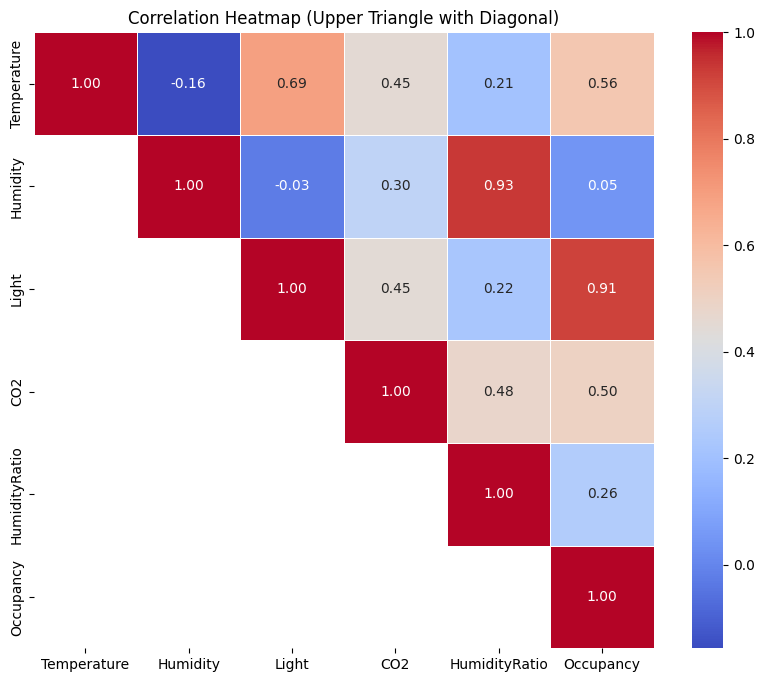

In [32]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Upper Triangle with Diagonal)')
plt.show()

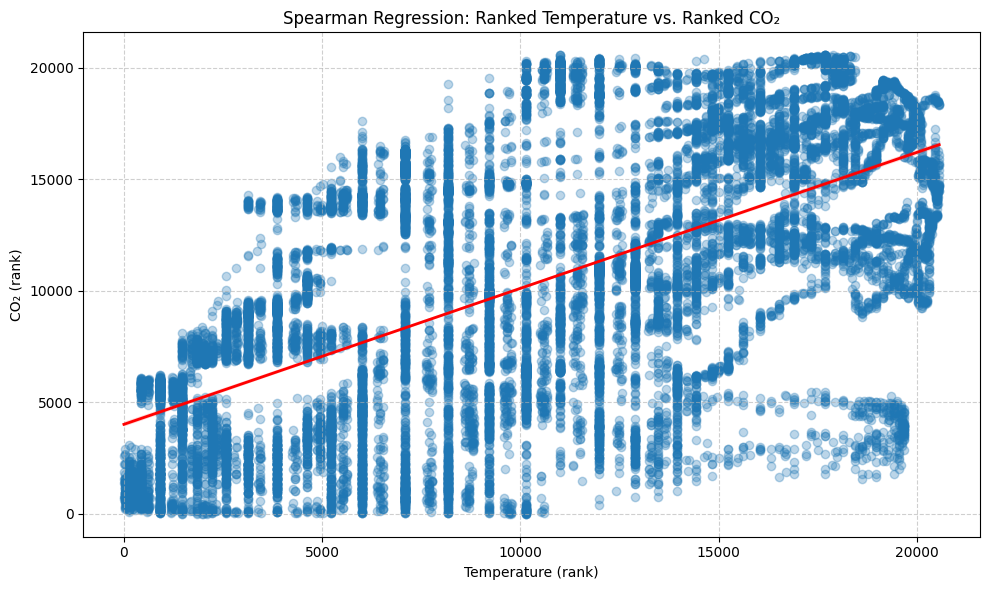

In [33]:
from scipy.stats import rankdata

df_ranked = df.copy()
df_ranked['Temperature'] = rankdata(df['Temperature'])
df_ranked['CO2'] = rankdata(df['CO2'])

# שרטוט רגרסיה על הדירוגים
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_ranked,
    x='Temperature',
    y='CO2',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red', 'linewidth': 2}
)

plt.title('Spearman Regression: Ranked Temperature vs. Ranked CO₂')
plt.xlabel('Temperature (rank)')
plt.ylabel('CO₂ (rank)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

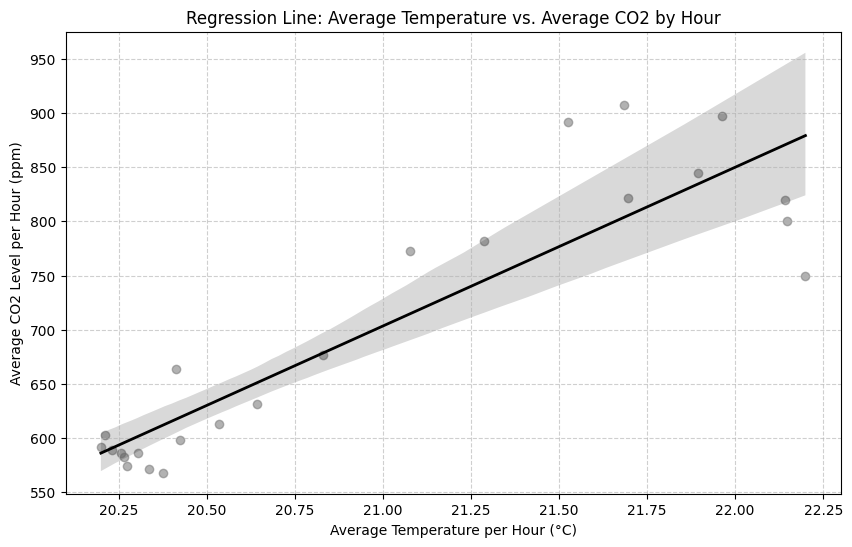

In [34]:

df['date'] = pd.to_datetime(df['date'])

df['hour'] = df['date'].dt.hour

hourly_avg_data = df.groupby('hour')[['Temperature', 'CO2']].mean().reset_index()

plt.figure(figsize=(10, 6))

sns.regplot(
    data=hourly_avg_data,
    x='Temperature',
    y='CO2',
    color='black',
    scatter_kws={'alpha':0.6, 'color':'gray'},
    line_kws={'color':'black', 'linewidth':2}
)

plt.title('Regression Line: Average Temperature vs. Average CO2 by Hour')
plt.xlabel('Average Temperature per Hour (°C)')
plt.ylabel('Average CO2 Level per Hour (ppm)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

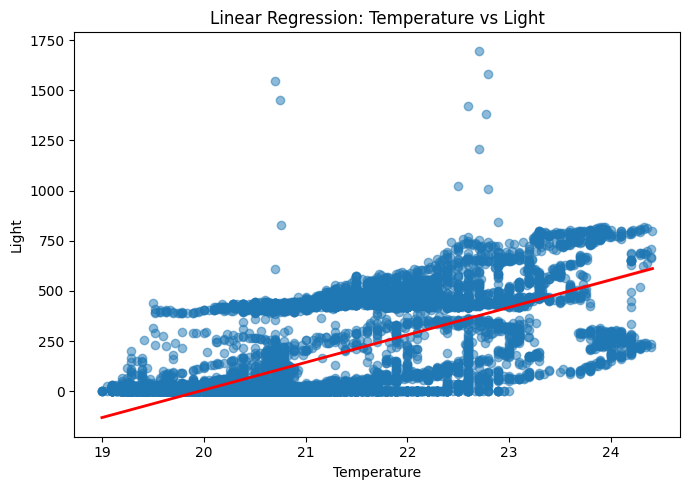

In [35]:
plt.figure(figsize=(7,5))
sns.regplot(x='Temperature', y='Light', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})
plt.title('Linear Regression: Temperature vs Light')
plt.xlabel('Temperature')
plt.ylabel('Light')
plt.tight_layout()
plt.show()

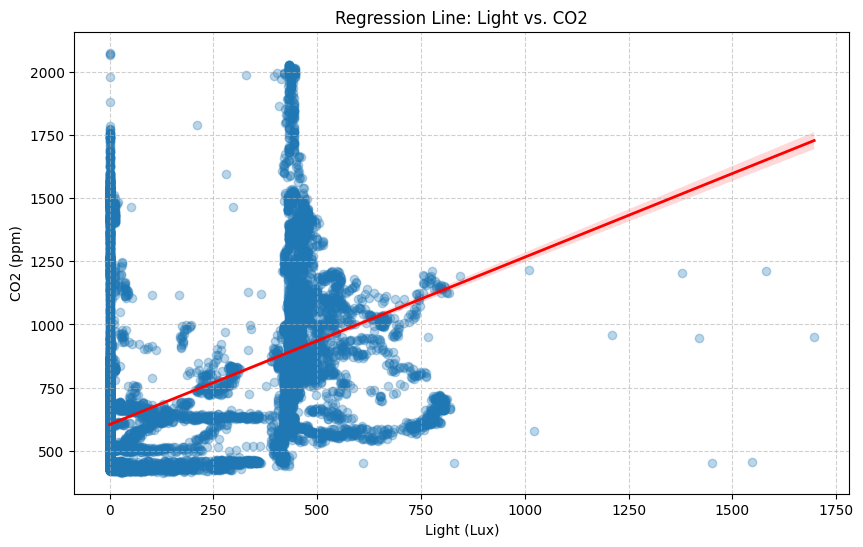

In [36]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Light', y='CO2', scatter_kws={'alpha':0.3}, line_kws={'color':'red', 'linewidth':2})
plt.title('Regression Line: Light vs. CO2')
plt.xlabel('Light (Lux)')
plt.ylabel('CO2 (ppm)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

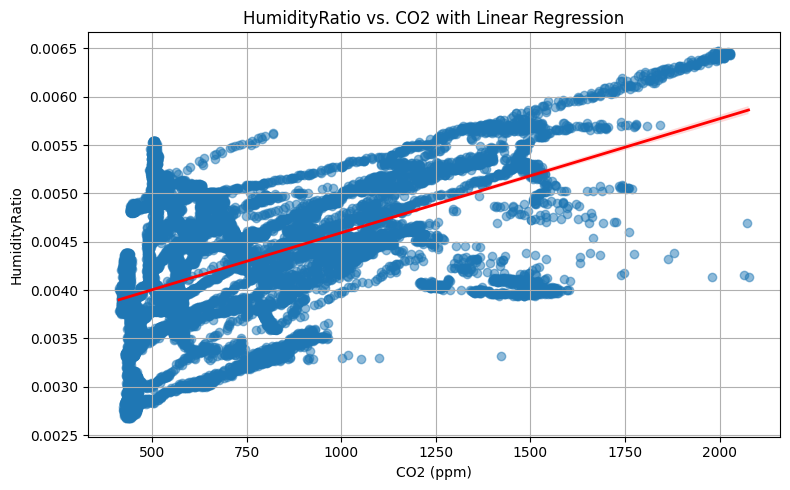

In [37]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x='CO2', y='HumidityRatio', scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})
plt.title('HumidityRatio vs. CO2 with Linear Regression')
plt.xlabel('CO2 (ppm)')
plt.ylabel('HumidityRatio')
plt.grid(True)
plt.tight_layout()
plt.show()

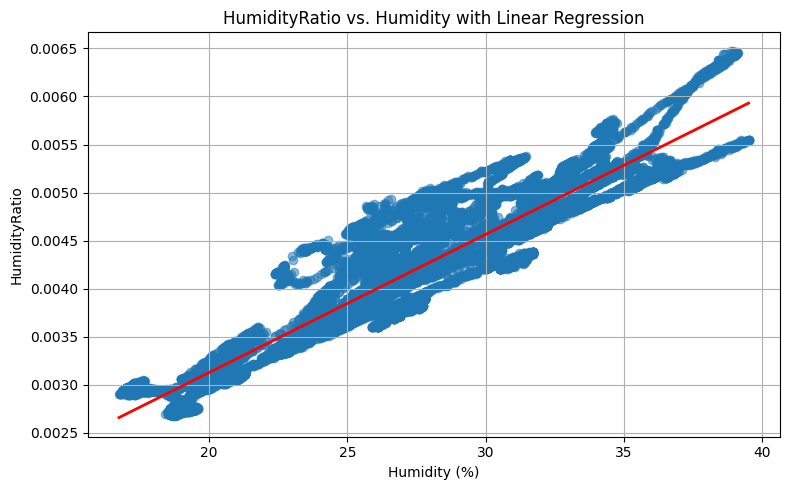

In [38]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x='Humidity', y='HumidityRatio', scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})
plt.title('HumidityRatio vs. Humidity with Linear Regression')
plt.xlabel('Humidity (%)')
plt.ylabel('HumidityRatio')
plt.grid(True)
plt.tight_layout()
plt.show()

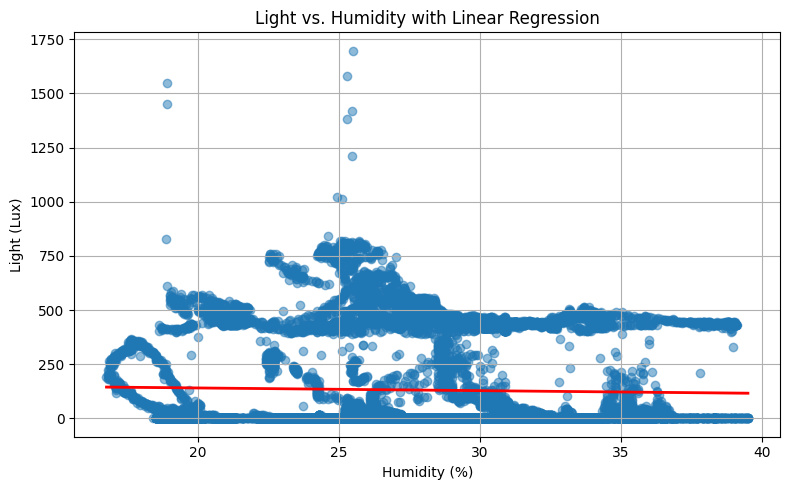

In [39]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x='Humidity', y='Light', scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})
plt.title('Light vs. Humidity with Linear Regression')
plt.xlabel('Humidity (%)')
plt.ylabel('Light (Lux)')
plt.grid(True)
plt.tight_layout()
plt.show()

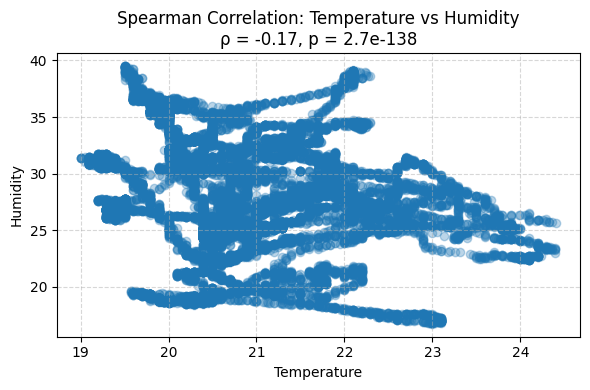

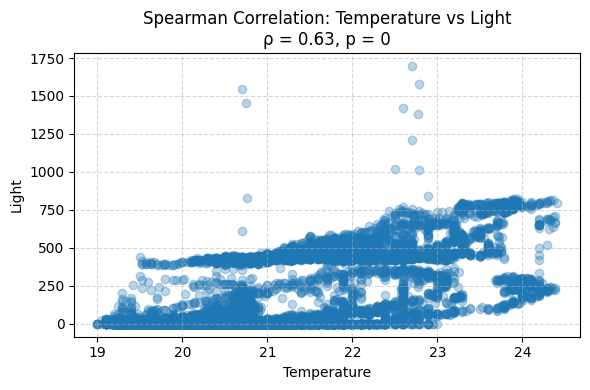

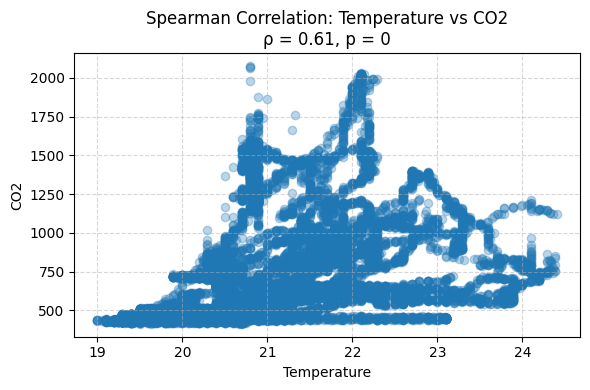

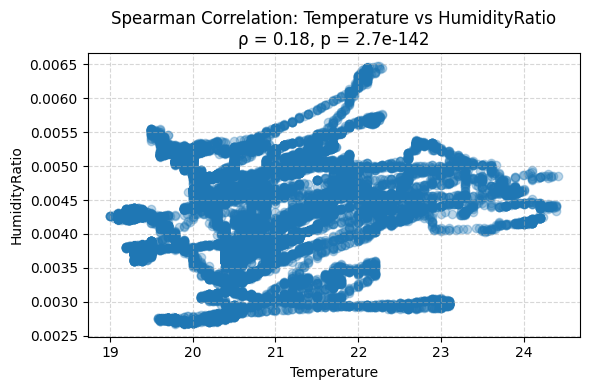

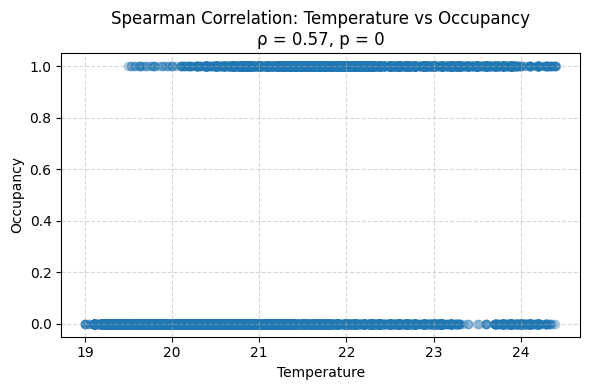

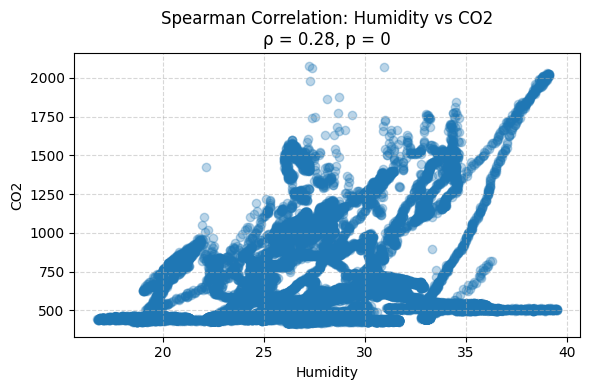

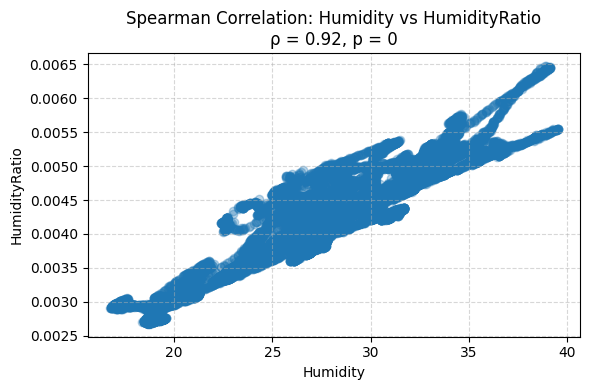

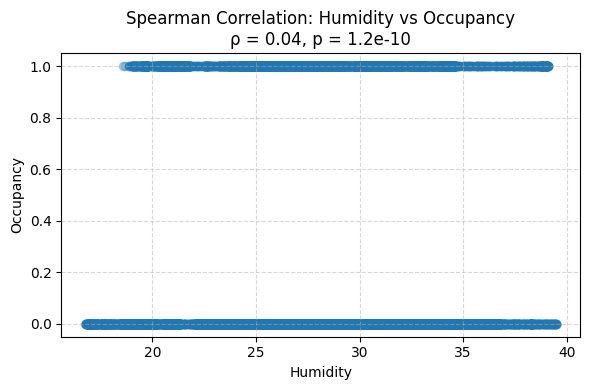

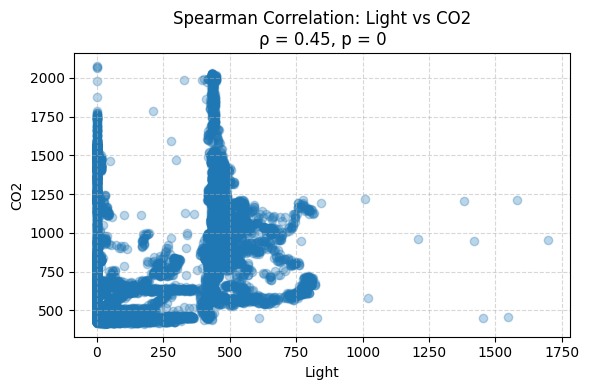

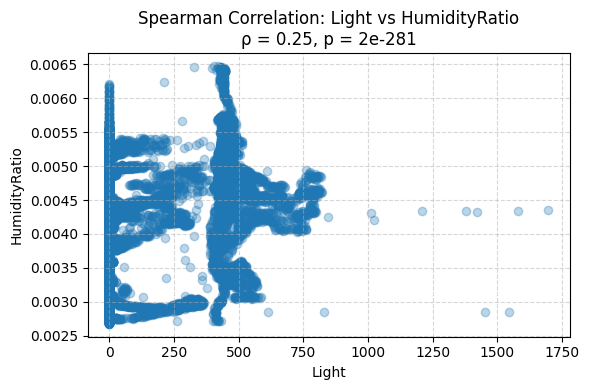

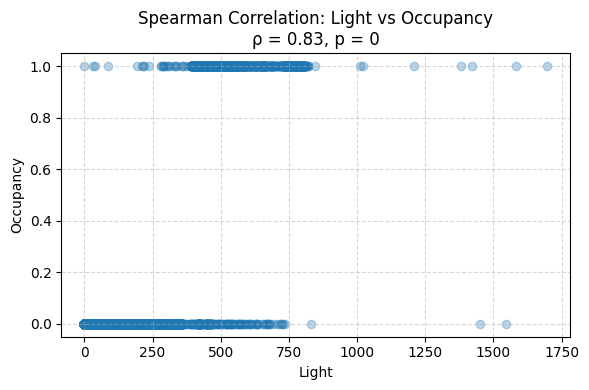

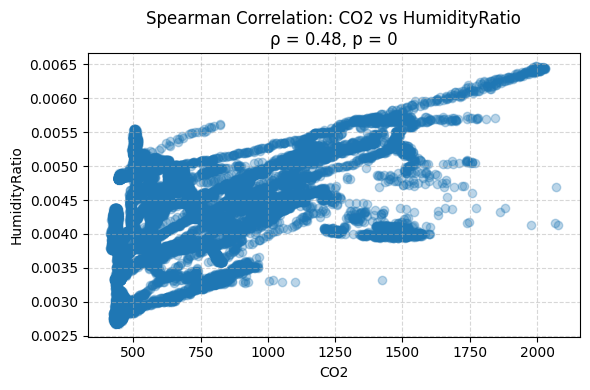

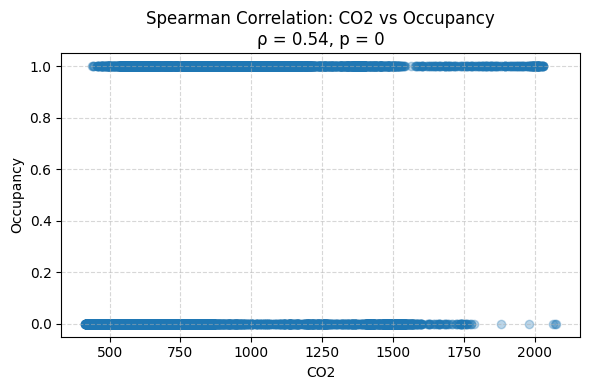

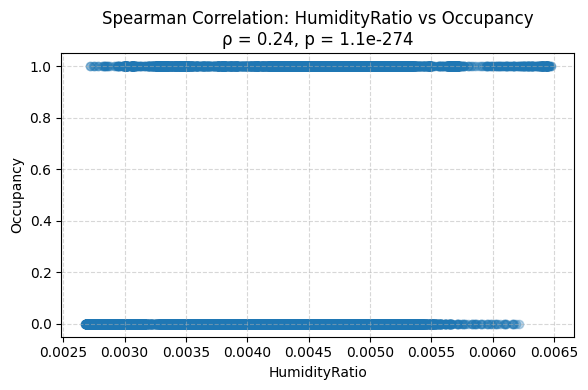

In [40]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Generate scatterplots for all pairs of numeric features, excluding self-pairs and filtering by p-value
for col1, col2 in itertools.combinations(numeric_cols, 2):
    coef, p = spearmanr(df[col1], df[col2])
    if p < 0.01:  # Only plot highly significant correlations
        plt.figure(figsize=(6, 4))
        plt.scatter(df[col1], df[col2], alpha=0.3)
        plt.title(f"Spearman Correlation: {col1} vs {col2}\n"
                  f"ρ = {coef:.2f}, p = {p:.2g}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

### Analyze Relationships

In [41]:
# Calculate Spearman correlation matrix
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
spearman_corr = df[numeric_cols].corr(method='spearman')

# Filter pairs with correlation above 0.6
high_corr_pairs = []
for col1 in spearman_corr.columns:
    for col2 in spearman_corr.index:
        if col1 != col2 and spearman_corr.loc[col1, col2] > 0.6:
            high_corr_pairs.append((col1, col2, spearman_corr.loc[col1, col2]))

# Remove duplicates (e.g., (A, B) and (B, A))
unique_high_corr_pairs = []
seen = set()
for col1, col2, corr in high_corr_pairs:
    if (col2, col1) not in seen:
        unique_high_corr_pairs.append((col1, col2, corr))
        seen.add((col1, col2))

# Display results
print("Features with Spearman correlation > 0.6:")
for col1, col2, corr in unique_high_corr_pairs:
    print(f"{col1} vs {col2}: ρ = {corr:.2f}")

Features with Spearman correlation > 0.6:
Temperature vs Light: ρ = 0.63
Temperature vs CO2: ρ = 0.61
Humidity vs HumidityRatio: ρ = 0.92
Light vs Occupancy: ρ = 0.83


### Define Logical Combinations

Investigate relationships between correlated variables and define meaningful ranges or thresholds for combined variables.

In [ ]:
# 1. Temperature vs Light
df['temp_bin'] = pd.cut(df['Temperature'], bins=[15,20,25,30])
df['light_bin'] = pd.cut(df['Light'], bins=[100,300,500,700])
grouped_temp_light = df.groupby(['temp_bin','light_bin'])['Occupancy'].mean().reset_index()
print("Temperature vs Light Occupancy Patterns:")
print(grouped_temp_light)

# 2. Temperature vs CO2
df['temp_bin'] = pd.cut(df['Temperature'], bins=[15,20,25,30])
df['co2_bin'] = pd.cut(df['CO2'], bins=[400,600,800,1000])
grouped_temp_co2 = df.groupby(['temp_bin','co2_bin'])['Occupancy'].mean().reset_index()
print("\nTemperature vs CO2 Occupancy Patterns:")
print(grouped_temp_co2)

# 3. Humidity vs HumidityRatio
df['humidity_bin'] = pd.cut(df['Humidity'], bins=[20,40,60,80])  
df['ratio_bin'] = pd.cut(df['HumidityRatio'], bins=[0.001,0.003,0.005,0.007])  
grouped_hum_ratio = df.groupby(['humidity_bin','ratio_bin'])['Occupancy'].mean().reset_index()
print("\nHumidity vs HumidityRatio Occupancy Patterns:")
print(grouped_hum_ratio)


Temperature vs Light Occupancy Patterns:
   temp_bin   light_bin  Occupancy
0  (15, 20]  (100, 300]   0.029412
1  (15, 20]  (300, 500]   0.862069
2  (15, 20]  (500, 700]        NaN
3  (20, 25]  (100, 300]   0.012516
4  (20, 25]  (300, 500]   0.916074
5  (20, 25]  (500, 700]   0.926413
6  (25, 30]  (100, 300]        NaN
7  (25, 30]  (300, 500]        NaN
8  (25, 30]  (500, 700]        NaN

Temperature vs CO2 Occupancy Patterns:
   temp_bin      co2_bin  Occupancy
0  (15, 20]   (400, 600]   0.004888
1  (15, 20]   (600, 800]   0.042254
2  (15, 20]  (800, 1000]        NaN
3  (20, 25]   (400, 600]   0.064683
4  (20, 25]   (600, 800]   0.255186
5  (20, 25]  (800, 1000]   0.648524
6  (25, 30]   (400, 600]        NaN
7  (25, 30]   (600, 800]        NaN
8  (25, 30]  (800, 1000]        NaN

Humidity vs HumidityRatio Occupancy Patterns:
  humidity_bin       ratio_bin  Occupancy
0     (20, 40]  (0.001, 0.003]   0.000000
1     (20, 40]  (0.003, 0.005]   0.217793
2     (20, 40]  (0.005, 0.007]   0.3

C:\Users\inbal\AppData\Local\Temp\ipykernel_12488\4102922321.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\inbal\AppData\Local\Temp\ipykernel_12488\4102922321.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\inbal\AppData\Local\Temp\ipykernel_12488\4102922321.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Define a combined logical feature

In [43]:
df['Comfort_Index'] = (
    (df['Temperature'].between(20,25)) &
    (df['Light'].between(300,700))
).astype(int)

df['Temp_CO2_Index'] = (
    (df['Temperature'].between(20,25)) &
    (df['CO2'].between(800,1000))
).astype(int)

df['Humidity_Index'] = (
    (df['Humidity'].between(20,40)) &
    (df['HumidityRatio'].between(0.005,0.007))
).astype(int)

### Random Forest with K‑Fold CV

In [44]:
X = df[['Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio']]  # add or drop features as needed
y = df['Occupancy']  # target

In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestRegressor(random_state=42)
cv_scores_rf = cross_val_score(rf, X, y, cv=kf, scoring='r2')

print("Random Forest CV R² per fold:", cv_scores_rf)
print("Random Forest Average R²:", np.mean(cv_scores_rf))


Random Forest CV R² per fold: [0.97206396 0.96232971 0.97024805 0.9665766  0.95846474]
Random Forest Average R²: 0.9659366111865803


- An R² of ~96.5% means model explains about 96.5% of the variance in occupancy.
- The spread is small (0.957–0.97).
- This stability means the model generalizes well across different splits.

=> No obvious signs of overfitting 

#### Feature Importance
##### See which predictors Random Forest thinks are most important:

In [46]:
rf.fit(X, y)
importances = rf.feature_importances_
for f, imp in zip(X.columns, importances):
    print(f"{f}: {imp:.3f}")

print("\n")
X_hum = df[['Humidity', 'HumidityRatio']]
rf.fit(X_hum, y)
for f, imp in zip(X_hum.columns, rf.feature_importances_):
    print(f, ":", round(imp, 4))


Temperature: 0.012
Light: 0.955
CO2: 0.016
Humidity: 0.009
HumidityRatio: 0.009


Humidity : 0.462
HumidityRatio : 0.538


#### We can get rid of one of the humidities since they are both contributing half.
#### Also we can get rid of Humidity_index

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestRegressor(random_state=42)
y = df['Occupancy']

feature_sets = {
    "Comfort_Index only": ['Comfort_Index'],
    "Temp_CO2_Index only": ['Temp_CO2_Index'],
    "Humidity_Index only": ['Humidity_Index'],
    "All Indices": ['Comfort_Index', 'Temp_CO2_Index', 'Humidity_Index'],
    "Full Model": ['Temperature','Light','CO2','Humidity']
}

results = {}
for name, features in feature_sets.items():
    X = df[features]
    cv_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')
    results[name] = np.mean(cv_scores)

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Avg CV R²'])
print(results_df)


                     Avg CV R²
Comfort_Index only    0.816699
Temp_CO2_Index only   0.114283
Humidity_Index only   0.024740
All Indices           0.821298
Full Model            0.965381


In [48]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestRegressor(random_state=42)
y = df['Occupancy']

feature_sets = {
    "Light + Comfort_Index + Temp_CO2_Index": ['Light','Comfort_Index','Temp_CO2_Index'],
    "Light + Comfort_Index + Temp_CO2_Index + Humidity": ['Light','Comfort_Index','Temp_CO2_Index','Humidity'],
    "Comfort_Index + Temp_CO2_Index": ['Comfort_Index','Temp_CO2_Index']
}

results = {}
for name, features in feature_sets.items():
    X = df[features]
    cv_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')
    results[name] = np.mean(cv_scores)

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Avg CV R²'])
print(results_df)


                                                   Avg CV R²
Light + Comfort_Index + Temp_CO2_Index              0.931618
Light + Comfort_Index + Temp_CO2_Index + Humidity   0.955520
Comfort_Index + Temp_CO2_Index                      0.817095


- We don’t need Humidity_Index at all → it was redundant and weak.
- We can drop HumidityRatio.

- Best minimal interpretable model:
    - Light + Comfort_Index + Temp_CO₂_Index + Humidity
    - This gets you R² ≈ 0.956 (almost full model).

### Conclusion: correlations don’t harm performance when using Random Forest; engineered features maintain high accuracy.